# Imports

In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import pywt

In [26]:
from IPython.display import clear_output

# Getting csv files

In [27]:
# Geting csv files
list_of_files = os.listdir("./")
csv_files = []

for _file in list_of_files:
    if _file.endswith(".csv"):
        csv_files.append(_file)

csv_files

['5_When_rebuilding.csv',
 '1_After_reconstruction.csv',
 '1_When_rebuilding.csv',
 '2_Before_renovation.csv',
 '6_After_reconstruction.csv',
 '2_When_rebuilding.csv',
 '4_Before_renovation.csv',
 '5_After_reconstruction.csv',
 '3_When_rebuilding.csv',
 '3_After_reconstruction.csv',
 '6_Before_renovation.csv',
 '4_After_reconstruction.csv',
 '1_Before_renovation.csv',
 '3_Before_renovation.csv',
 '6_When_rebuilding.csv',
 '2_After_reconstruction.csv',
 '5_Before_renovation.csv',
 '4_When_rebuilding.csv']

# Functions

In [28]:
def custom_slicer(signal, fs=825.8):
    '''
    Returns: first 10 seconds
             last 30 seconds of the signal
    '''

    return signal[:int(fs * 10)], signal[int(-30 * fs):]

In [29]:
def slicer(signal, fs=825.8, chunk_size_seconds=10):
    '''
    Returns: sliced signal in desired seconds chunks
    Note: size of the signal should be a true nominator of chunk size
    '''
    chunk_size = int(fs * chunk_size_seconds)
    return [signal[_ * chunk_size : (_+1)*chunk_size ] for _ in range(int(len(signal)/chunk_size))]

In [30]:
def dir_creator(csv_file_name):
    '''
    Creating directoies for each column of csv files
        to save heatmaps into them
    '''
    sensor_number = csv_file_name.split('_')[0]
    file_name = csv_file_name.split('.')[0]

    # Define the sensor directory name
    sensor_dir = f"sensor_{sensor_number}"

    if not os.path.exists(sensor_dir):
        os.mkdir(sensor_dir)
    
    # Change directory to the sensor directory
    os.chdir(sensor_dir)
    
    # Create the main directory for the current file
    if not os.path.exists(file_name):
        os.mkdir(file_name)
        os.mkdir(f"{file_name}/train_out")
        os.mkdir(f"{file_name}/train_in")

    # Change back to the original directory
    os.chdir("..")

In [31]:
def save_heatmap(csv_file_name, column, counter, train_status):
    '''
    Saving plots in png format in their specific path
    '''
    no_ext_csv_file_name = csv_file_name.split('.')[0]
    sensor_number = csv_file_name.split('_')[0]
    sensor_dir = f"sensor_{sensor_number}"
    
    path = f"{sensor_dir}/{no_ext_csv_file_name}/{train_status}/{sensor_number}_{no_ext_csv_file_name}_{column}_{counter}.png"
    plt.savefig(path , bbox_inches='tight', pad_inches=0)

In [44]:
def signal_to_heatmap(signal):
    '''
    Returns the heatmap of signal
    '''
    # Desired size in pixels
    width_px = 50
    height_px = 50

    # DPI (dots per inch)
    dpi = 80

    # Convert to inches
    width_in = width_px / dpi
    height_in = height_px / dpi

    # Set the size of the heatmap
    fig = plt.figure(figsize=(width_in, height_in), dpi=dpi)
    ax = fig.add_subplot()
    ax.axis('off')
    
    sns.heatmap(signal, xticklabels=False, yticklabels=False, cbar=False)

In [33]:
# def signal_to_heatmap(coefficients, frequencies):
#     '''
#     Returns the heatmap of signal
#     '''
#     # power = (abs(coefficients)) ** 2
#     power = coefficients
#     period = 1. / frequencies
    
#     # Setting contourlevels automatically in "10" different color range
#     # max_power = np.log2(power.max())
#     # min_power = np.log2(power.min())
#     max_power = power.max()
#     min_power = power.min()

#     # levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
#     # contourlevels = np.log2(levels)
    
#     contourlevels = np.linspace(min_power, max_power, num=30)

#     fs = 825.8
     
#     # Generate a time array based on the length of the signal or coefficients
#     time = np.linspace(0, len(coefficients[0]) / fs, num=len(coefficients[0]))
#     cmap = plt.cm.seismic

#     # Desired size in pixels
#     width_px = 600
#     height_px = 600

#     # DPI (dots per inch)
#     dpi = 300

#     # Convert to inches
#     width_in = width_px / dpi
#     height_in = height_px / dpi
    
#     # Set the size of the heatmap
#     fig, ax = plt.subplots(figsize=(width_in, height_in), dpi=dpi)
#     # im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
#     im = ax.contourf(time, period, power, contourlevels, extend='both',cmap=cmap)
    
#     # yticks = np.arange(np.ceil(period.min()), np.ceil(period.max()))
#     yticks = np.linspace(period.min(), period.max(), num=10)

#     ax.set_yticks(yticks)
#     # ax.set_yticklabels(yticks)
#     ax.set_yticklabels(np.round(yticks, 2))
#     ax.invert_yaxis()
#     ylim = ax.get_ylim()
#     ax.set_ylim(ylim[0], ylim[1])

#     plt.show()

In [34]:
def remove_five_zeros(arr):
    """Remove sequences of 5 successive zeros from an array."""
    result = []
    zero_count = 0

    for i in range(len(arr)):
        if arr[i] == 0:
            zero_count += 1
        else:
            if zero_count == 5:
                result = result[:-5]  # Remove the last 5 zeros from the result
            zero_count = 0
            result.append(arr[i])
        
        # If we've reached the end and have exactly 5 zeros at the end
        if i == len(arr) - 1 and zero_count == 5:
            result = result[:-5]
    
    return np.array(result)

In [35]:
def continuous_wavelet_transform(signal, fs, min_freq, max_freq, wavelet_name='morl'):
    """
    Perform Continuous Wavelet Transform on a given signal with specified frequency range.
    return: (coefficients, frequencies) tuple
             - coefficients: 2D array of CWT coefficients
             - frequencies: Corresponding frequencies for the scales
    """
    # Center frequency of the Morlet wavelet
    center_freq = pywt.central_frequency(wavelet_name)
    
    # Calculate scales based on desired frequency range
    min_scale = center_freq * fs / max_freq
    max_scale = center_freq * fs / min_freq
    scales = np.arange(min_scale, max_scale)
    
    # Perform the Continuous Wavelet Transform
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet_name, sampling_period=1/fs)
    
    return coefficients, frequencies

# Setting min and max frequency

In [36]:
# Initializing fs
fs=825.8

In [37]:
# Reading files
df = pd.read_csv("./1_After_reconstruction.csv")

# Nan to zero
df = df.fillna(0)
    
# Loading each column of df into dict
columns_dict = {}
for col in df.columns:
    columns_dict[col] = df[col].to_numpy()
# Removing first incremental column
columns_dict.pop('Unnamed: 0')

# Removing 5 successive zeros
signal = remove_five_zeros(columns_dict['201'])

In [38]:
# Perform Fourier Transform to analyze frequency content
frequencies = np.fft.fftfreq(len(signal), d=1/fs)
fft_magnitude = np.abs(np.fft.fft(signal))

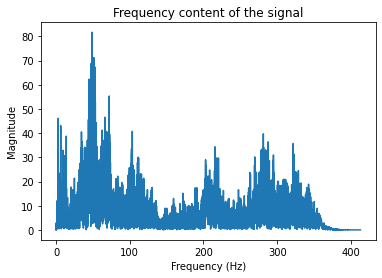

In [39]:
# Plot the Fourier Transform
plt.figure()
plt.plot(frequencies[:len(frequencies)//2], fft_magnitude[:len(frequencies)//2])
plt.title("Frequency content of the signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

In [40]:
min_freq = 1
max_freq = 400

# Creating heatmaps of CWT signals

In [41]:
wavelet_name='morl'

In [42]:
information = {}
number_of_each_class_images = {
    "After" : 0,
    "When": 0,
    "Before": 0
}

Processing: 5_When_rebuilding.csv:	 Column 0
		. Removing 5 successive zeros
		. Number of images when train is in: 2
		. Calculating CWT transform and heatmap creation


KeyboardInterrupt: 

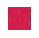

In [43]:
# Reading and processing csv files
for csv_file in csv_files:
    # Reading files
    df = pd.read_csv(csv_file)

    # Nan to zero
    df = df.fillna(0)
    
    # Loading each column of df into dict
    columns_dict = {}
    for col in df.columns:
        columns_dict[col] = df[col].to_numpy()
    # Removing first incremental column
    columns_dict.pop('Unnamed: 0') 

    # Creating dirs
    dir_creator(csv_file)

    information[csv_file] = {}

    for col in columns_dict.keys():
        clear_output(wait=True)
        heatmaps_counter = 1
        information[csv_file][col] = {}
        print(f"Processing: {csv_file}:\t Column {col}")

        # Removing 5 successive zeros
        print("\t\t. ", end="")
        print("Removing 5 successive zeros")
        columns_dict[col] = remove_five_zeros(columns_dict[col])
        
        # Printing the amount of images when train is in (40 seconds is when train is out)
        print("\t\t. ", end="")
        print(f"Number of images when train is in: { int( (len(columns_dict[col]) // fs - 40) // 10 ) }")
        
        # Recording information
        information[csv_file][col][f"Images count, train in"] = int( (len(columns_dict[col]) // fs - 40) // 10 )
        information[csv_file][col][f"Images count, train out"] = 4
        information[csv_file][col][f"Whole signal length in seconds"] = int(len(columns_dict[col]) // fs)
        class_name = csv_file.split('_')[1]
        number_of_each_class_images[class_name] += 1

        # handling train out part
        first_10, last_30 = custom_slicer(columns_dict[col], fs)
        last_30_signals_chunked = slicer(last_30)
        
        # Calculating CWT transform and heatmap creation
        print("\t\t. ", end="")
        print("Calculating CWT transform and heatmap creation")
        coefficients, frequencies = continuous_wavelet_transform(first_10, fs, min_freq, max_freq, wavelet_name)
        signal_to_heatmap(coefficients)
        save_heatmap(csv_file, col, heatmaps_counter, "train_out")
        heatmaps_counter += 1
        
        for sig_chunk in last_30_signals_chunked:
            coefficients, frequencies = continuous_wavelet_transform(sig_chunk, fs, min_freq, max_freq, wavelet_name)
            signal_to_heatmap(coefficients)
            save_heatmap(csv_file, col, heatmaps_counter, "train_out")
            heatmaps_counter += 1
        
        # handling train in part
        train_in_sig_chunks = slicer(columns_dict[col][int(10*fs):int(-30*fs)])
        for sig_chunk in train_in_sig_chunks:
            coefficients, frequencies = continuous_wavelet_transform(sig_chunk, fs, min_freq, max_freq, wavelet_name)
            signal_to_heatmap(coefficients)
            save_heatmap(csv_file, col, heatmaps_counter, "train_in")
            heatmaps_counter += 1

In [ ]:
information

In [ ]:
number_of_each_class_images